Example of generation of one dimentional gaussian process 
and fitting by cosmogp (without error for the moment)

In [1]:
import cosmogp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

np.random.seed(1)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Generation of gaussian process (1D and centred):

$Y\left(X \right) \sim {\cal N}\left(0,K\right)$ 

Where $K$ is the Kernel define like you want. In this peculiar cas it will be define as a Radial Basis Function (RBF) :


$K_{ij}=\sigma^2 \ \exp\left[-\frac{1}{2} \left(\frac{X_i-X_j}{l}\right)^2\right]$

$\sigma$ and $l$ are the Kernel hyperparameter and the goal will be to fit them. $sigma$ represent the standard deviation from the mean (0 here) and $l$ represnet how the data are correalted in $X$ direction.

In this example $\sigma=0.5$ and $l=1$


In [2]:
n_object = 1000 # number of object to fit
n_point = 30 # number of points per object
grid = np.linspace(-10,30,n_point) # fixed grid where gp will be generated
k = cosmogp.rbf_kernel_1d(grid,np.array([0.5,1]),0) # build the kernel with fixed hyperparameter
y = np.random.multivariate_normal(np.zeros_like(grid), k, size=n_object) # generation of gaussian process

How looks like gaussian process :

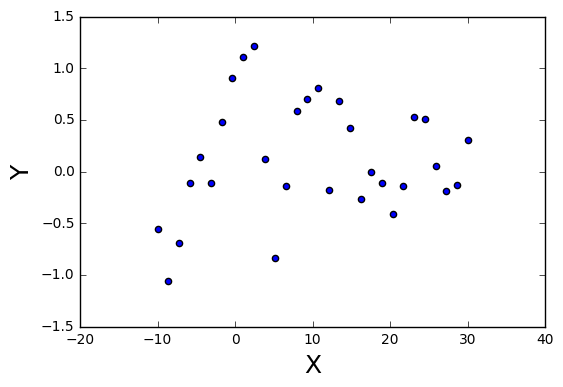

In [3]:
plt.figure()
plt.scatter(grid,y[0]) # one example of generated gaussian process 
plt.xlabel('X',fontsize=18)
plt.ylabel('Y',fontsize=18)

Now cosmogp will fit hyperparameter for the first object by doing :

In [4]:
gp = cosmogp.gaussian_process(y[0],grid) # init cosmogp with one object                                                                                                                                                                                                   
gp.find_hyperparameters() # search hyperparameters                                                                                                                                                                     

The set of hyperparameter is given by :

In [5]:
print gp.hyperparameters

[ 0.55795006  1.27906331]


And you get your interpolation and the covariance error matrix by doing. The result is inside the plot.

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


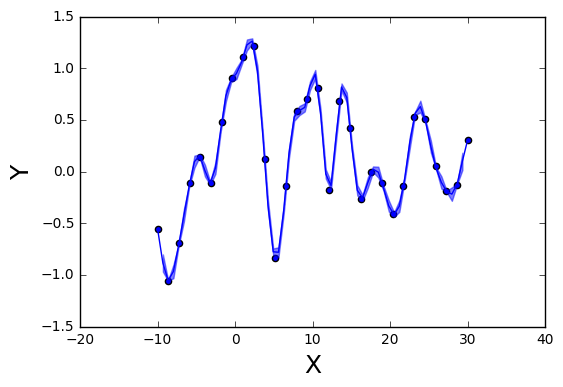

In [6]:
new_grid = np.linspace(-10,30,60) # new grid where you want to have your interpolation value
gp.get_prediction(new_binning=new_grid) # get interpolation 
Y_err=np.sqrt(np.diag(gp.covariance_matrix[0])) # diagonal error on the interpolation 

plt.figure()
plt.scatter(grid,y[0]) # one example of generated gaussian process 
plt.plot(np.linspace(-10,30,60),gp.Prediction[0]) # result of interpoaltion for the fitted hyperparameter 
plt.fill_between(new_grid,gp.Prediction[0]-Y_err,gp.Prediction[0]+Y_err,color='b',alpha=0.5 )
plt.xlabel('X',fontsize=18)
plt.ylabel('Y',fontsize=18)


This is possible to fit all the gaussian process generated with cosmogp and looks distribution of hyperparameters and the pull. If the cosmogp works well it should find a gaussian distribution with a standrad deviation of 1. The pull for a given point will be define as:

$\text{pull}_{X_i }= \frac{y_{\lambda n t_i}' - y_{\lambda n t_i}}{\sqrt{\text{cov}\left(\textbf{y}'_{ii}\right)}}$

where $y_i$ is your initial dataset at the postion $x_i$, $y_i'$ your interpolation value at the position $x_i$ without taking into account the contribution of $y_i$ in the computation of itself, and $\text{cov}\left(\textbf{y}'_{ii}\right)$ is the diagonal part of the error on the intepolation at the position $X_i$




In [7]:
hyperparmeter_sigma = np.zeros(n_object)
hyperparmeter_l = np.zeros(n_object)
pull = np.zeros(np.shape(y))

for i in range(n_object):
    
    gp = cosmogp.gaussian_process(y[i],grid) # init cosmogp with one object 
    gp.find_hyperparameters() # search hyperparameters 
    gp.get_prediction(new_binning=np.linspace(-10,30,60)) # get interpolation
    
    hyperparmeter_sigma[i] = gp.hyperparameters[0]
    hyperparmeter_l[i] = gp.hyperparameters[1]
    
    bp = cosmogp.build_pull([y[i]],[np.zeros_like(y[i])],[grid],grid,np.zeros_like(grid),gp.hyperparameters)                                           
    bp.compute_pull(diFF=None)    
    pull[i] = bp.PULL

    

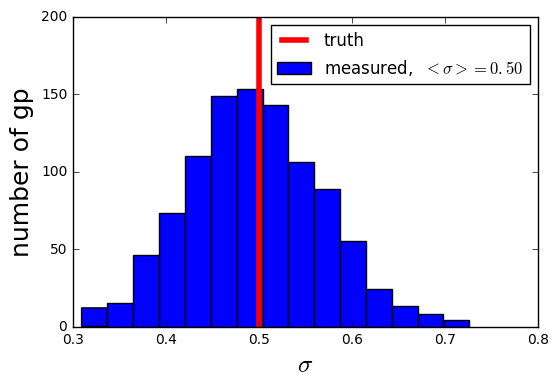

In [8]:
plt.figure()
plt.hist(hyperparmeter_sigma,bins=15,label='measured,  $<\sigma>=%.2f$'%np.mean(hyperparmeter_sigma))
plt.plot([0.5,0.5],[0,200],'r',linewidth=4,label='truth')
plt.xlabel('$\sigma$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.xlim(0.3,0.8)
plt.legend()

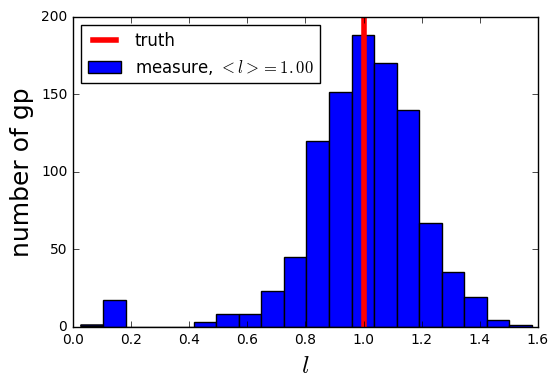

In [9]:
plt.figure()
plt.hist(hyperparmeter_l,bins=20,label='measure, $<l>=%.2f$'%np.mean(hyperparmeter_l))
plt.plot([1,1],[0,200],'r',linewidth=4,label='truth')
plt.xlabel('$l$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.legend(loc=2)

(-5, 5)

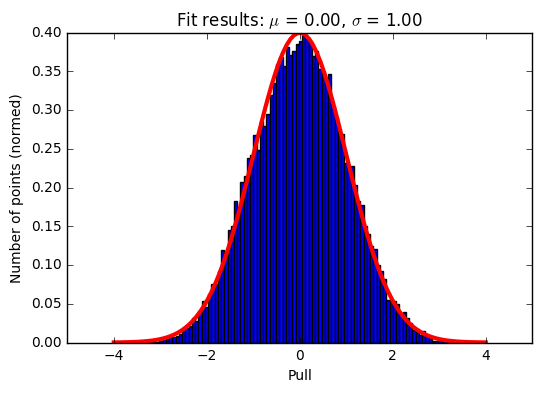

In [10]:
pull = pull.reshape((n_object*n_point,1))

from scipy.stats import norm as normal
average_pull, std_pull = normal.fit(pull)

plt.hist(pull,bins=100,normed=True)
xmin, xmax = plt.xlim()
X = np.linspace(xmin, xmax, 100)
PDF = normal.pdf(X, average_pull, std_pull)
plt.plot(X, PDF, 'r', linewidth=3)
title = r"Fit results: $\mu$ = %.2f, $\sigma$ = %.2f" % (average_pull, std_pull)
    
plt.title(title)
plt.ylabel('Number of points (normed)')
plt.xlabel('Pull')

plt.xlim(-5,5)

In average you refond value of hyperparameters and residuals are as expected (gaussian distributed with 1 as standard deviation)

However all those data were generate with the same distribution. You can imagine that you want to fit all of them with the product off all the likelihood of each observation. With cosmogp this is possible. 

In the following example I will not keep the same grid for each observation, which will looks like more realistic data 

In [11]:
n_object = 1000 # number of object to fit

all_grid = []
all_y = []

for i in range(n_object): # generate object not on the same grid of observation 
    n_point = int(np.random.uniform(10,20)) # random number of points for one object
    grid = np.linspace(-10,30,n_point) # fixed grid where gp will be generated
    k = cosmogp.rbf_kernel_1d(grid,np.array([0.5,1]),0) # build the kernel with fixed hyperparameter
    y = np.random.multivariate_normal(np.zeros_like(grid), k) # generation of gaussian process
    all_grid.append(grid)
    all_y.append(y)

Now you can find hyperparameter and interpoaltion in the same time, by maximazing only one likelihood: 

In [12]:
gp = cosmogp.gaussian_process_nobject(all_y,all_grid) # init with n object, n != 1
gp.find_hyperparameters() # search hyperparameters    

The set of hyperparameter is given by :

In [13]:
print gp.hyperparameters

[ 0.50139029  1.00257774]


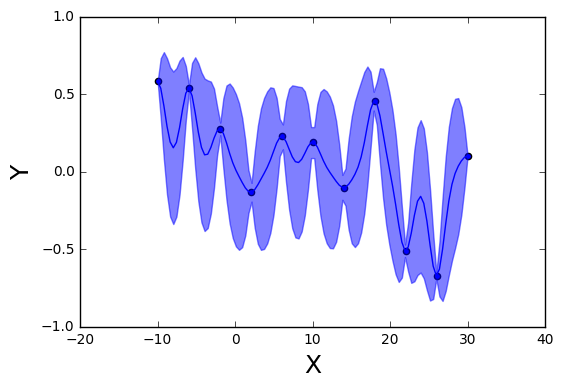

In [14]:
new_grid = np.linspace(-10,30,100) # new grid where you want to have your interpolation value
gp.get_prediction(new_binning=new_grid) # get interpolation 
Y_err=np.sqrt(np.diag(gp.covariance_matrix[0])) # diagonal error on the interpolation 

plt.figure()
plt.scatter(all_grid[0],all_y[0]) # one example of generated gaussian process 
plt.plot(np.linspace(-10,30,100),gp.Prediction[0]) # result of interpoaltion for the fitted hyperparameter 
plt.fill_between(new_grid,gp.Prediction[0]-Y_err,gp.Prediction[0]+Y_err,color='b',alpha=0.5 )
plt.xlabel('X',fontsize=18)
plt.ylabel('Y',fontsize=18)

And you can compute the pull like before (execpt in this case you can make the plot automatically): 

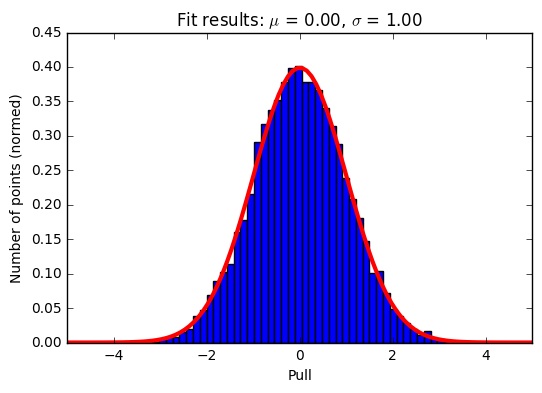

In [15]:
bp = cosmogp.build_pull(all_y,gp.y_err,all_grid,np.linspace(-20,40,30),np.zeros(30),gp.hyperparameters)                                           
bp.compute_pull(diFF=None)    
bp.plot_result()    

The of hyperparameters are the same as the input parameters and the distribution of the pull is like expected, so cosmogp do what it was done for. 